### Statistical Analysis of Generated Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
%matplotlib widget

#### Data distribution

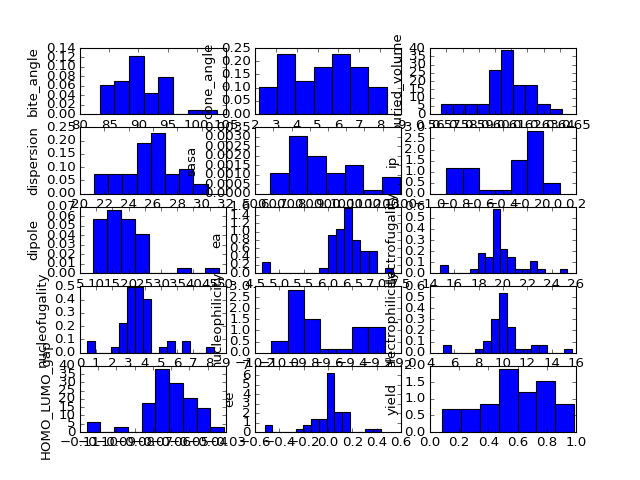

In [11]:
# Histograms of data

oh = pd.read_excel('descriptors_OH.xlsx').dropna()
mace_averaged_oh = oh.groupby(['Cas']).mean()
fig, ax = plt.subplots(5,3)
descriptors = mace_averaged_oh.columns

descriptor_count = 0
for i in range(5):
    for j in range(3):
        
        ax[i, j].hist(x = mace_averaged_oh[descriptors[descriptor_count]], bins='auto', density=True)
        ax[i, j].set_ylabel(descriptors[descriptor_count])
        descriptor_count+=1
        


#### MLR on selected data points

In [4]:
from sklearn.linear_model import LinearRegression
from pandas import read_excel
import numpy as np



def MLR(X, y):
    # data = read_excel('PCA.xlsx')
    # X = np.array([list(data['steric']),  list(data['elec']), list(data['geom'])]).T
    # y = list(data['yield'])

    reg = LinearRegression().fit(X, y)

    print('R2 = ', reg.score(X,y))

    # print('coef: ', reg.coef_, 'intercept:', reg.intercept_)
    return reg.coef_, reg.intercept_


#### PCA

In [23]:
from sklearn.decomposition import PCA
from umap import UMAP
import itertools

data = mace_averaged_oh
geom_keys = ['bite_angle', 'cone_angle']
steric_keys = ['dispersion', 'dipole', 'sasa', 'buried_volume']
elec_keys = ['HOMO_LUMO_gap', 'ea','nucleofugality', 'electrofugality', 'electrophilicity', 'nucleophilicity']

pca1 = PCA(n_components=1)
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=3)

u_geom = pca1.fit_transform(data[geom_keys]) 
u_steric = pca2.fit_transform(data[steric_keys])
u_elec = pca3.fit_transform(data[elec_keys])


data['Cas'] = data.index
dataframe = pd.DataFrame()

descriptor_order = 1

dataframe['steric1'] = u_steric[:, 0]
dataframe['steric2'] = u_steric[:, 1]
dataframe['elec1'] = u_elec[:, 0]
dataframe['elec2'] = u_elec[:, 1]
dataframe['elec3'] = u_elec[:, 2]
dataframe['geom'] = u_geom[:, 0]

### Add second order interactions
for comb in itertools.combinations(['steric1','steric2', 'elec1','elec2','elec3', 'geom' ], 2):
    dataframe["_".join(comb)] = dataframe[comb[0]] * dataframe[comb[1]]

# for index, key1 in enumerate(dataframe.keys()):
#     for key2 in dataframe.keys()[index:]:
#         dataframe[key1 + '_' + key2] = dataframe[key1]*dataframe[key2] 

dataframe['yield'] = data['yield'].to_list()
dataframe['ee'] = data['ee'].to_list()

dataframe['Cas'] = data['Cas'].to_list()
dataframe['label_yield'] = pd.cut(x = dataframe['yield'], bins=[0, 0.8, 1],
                     labels=[0, 1])

dataframe.to_excel('PCA3_good_substrate_.xlsx')

# X = np.array([list(dataframe['steric1']),list(dataframe['steric2']), list(dataframe['elec1']),  list(dataframe['elec2']), list(dataframe['elec3']), list(dataframe['geom'])])
# print(X)
# X2 = X**2
# X3 = X**3

X = dataframe.drop(['Cas', 'yield', 'label_yield', 'ee'], axis=1)
# X = np.array([X, X2, X3])
y = dataframe ['label_yield']
# X = list(dataframe['elec1'])
# y = list(dataframe['elec3'])

MLR(X, y)

               bite_angle  cone_angle  buried_volume  dispersion         sasa  \
Cas                                                                             
133545-25-2     90.245103  344.988319       0.621809   29.453907  1263.194993   
1365531-89-0    88.692857  343.767047       0.602328   28.043970  1026.213767   
1365531-98-1    90.246765  344.992065       0.615187   30.504563  1296.374414   
136705-62-9     84.524578  344.998074       0.578905   21.902478   625.851554   
136705-64-1     84.342845  345.508022       0.571882   22.162007   668.632181   
137219-86-4     86.495512  343.234608       0.601420   25.033388  1000.319934   
139139-86-9     91.842159  343.526388       0.611687   27.049326   850.969165   
1429939-35-4   103.460703  346.008974       0.629853   26.754494  1019.142102   
145214-59-1     87.419442  342.441037       0.587315   22.810697   748.988684   
147253-67-6     84.184417  345.708093       0.566411   21.140504   583.962160   
155806-35-2     94.856467  3

(array([-2.23392584e-03,  3.65742450e-03,  6.38906167e-02, -3.05181006e-01,
        -4.62571880e+00, -1.28888749e-04,  1.62305253e-05,  1.00649442e-03,
        -2.63883296e-03, -2.25953371e-02, -1.52698726e-04, -6.54264168e-03,
        -5.87062783e-02,  8.66698295e-02,  7.55211454e-03,  7.50732734e-02,
         7.34421391e-01,  2.40681953e-03,  4.89054286e+00, -1.36437861e-01,
        -4.09958793e-01]),
 -0.05972510723799715)

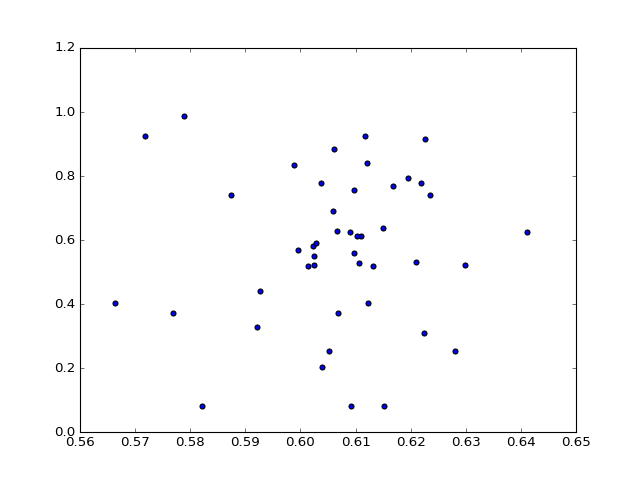

In [ ]:
plt.close('all')
plt.scatter(mace_averaged_oh['buried_volume'], mace_averaged_oh['yield'])
plt.show()

# Function for confidence intervals

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


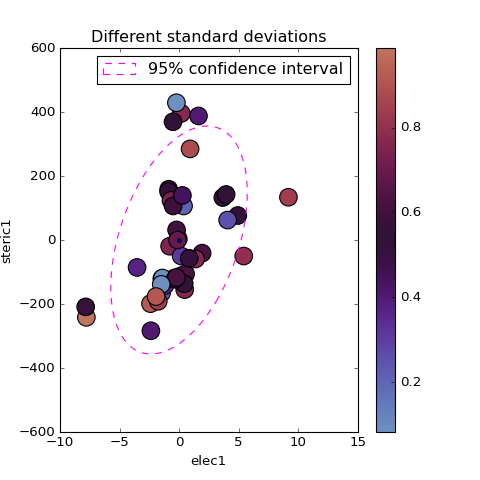

In [30]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))
plt.style.use('classic')
plt.rcParams['image.cmap'] = new_cmap

p1 = 'elec1'
p2 = 'steric1'
heat_map = 'yield'

### Change all ferrocenes
x = dataframe[p1] 
y = dataframe[p2] 

mu = np.average(x), np.average(y)

sc = ax_nstd.scatter(x, y, c=mace_averaged_oh[heat_map], s=250)
fig.colorbar(sc)


# confidence_ellipse(x, y, ax_nstd, n_std=1,
#     label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
    label=r'95% confidence interval', edgecolor='fuchsia', linestyle='--')

# confidence_ellipse(x, y, ax_nstd, n_std=3,
#     label=r'$3\sigma$', edgecolor='blue', linestyle=':')


annot = ax_nstd.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
names = list(dataframe['Cas'])

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    # annot.get_bbox_patch().set_facecolor(cmap(np.linalg.norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    try:
        if event.inaxes == ax_nstd:
            cont, ind = sc.contains(event)
            if cont:
                print(annot, end=" "*50 + '\r')
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    except Exception:
        pass
    
fig.canvas.mpl_connect("motion_notify_event", hover)

ax_nstd.scatter(mu[0], mu[1], s=10)
ax_nstd.set_title('Different standard deviations')
ax_nstd.set_xlabel(p1)
ax_nstd.set_ylabel(p2)
fig.set_facecolor('white')
ax_nstd.legend()

plt.savefig("std_{}_{}_heatmap_{}.png".format(p1, p2, heat_map), dpi=400, bbox_inches='tight')
plt.show()  

## Multinomial Logistic Regression

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


arr = np.linspace(0, 50, 100).reshape((10, 10))

fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('twilight')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()
plt.close('all')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


df = pd.read_excel('PCA3_good_substrate_.xlsx')

X = df.drop(['yield', 'Cas', 'label_yield'], axis=1)

y = df['label_yield']

random_states = 30
store = []
for random_state in range(random_states):
    X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                    random_state=random_state, 
                                    test_size=0.25, 
                                    shuffle=True)
    lr = LogisticRegression(max_iter=1800)
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    prob = preds==y_test

    store.append(np.average(prob))

print('size=', len(X_test))
print('avg =', np.average(store), np.max(store), np.argmax(store))
# print(np.average(prob))
# a = pd.DataFrame(preds)
# a.to_excel('preds.xlsx')



c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

size= 12
avg = 0.375 0.5 1


c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## MLR

In [ ]:
random_states = 10
store = []
for random_state in range(random_states):
    X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                    random_state=random_state, 
                                    test_size=0.25, 
                                    shuffle=True)
    
    model = LinearRegression()
    reg  = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('R2 = ', reg.score(X_test, y_test))

R2 =  -3.0507056578381
R2 =  -28864.64613641307
R2 =  -5.326933054306207
R2 =  -5.945261478214187
R2 =  -4.707926948553107
R2 =  -16.54895350422437
R2 =  -8.521664292143711
R2 =  -11.939156409620907
R2 =  -5.362153982389718
R2 =  -1.9118008614650628


### ExtraTreesClassifier

Top features:
1. feature 10 (0.087289)
2. feature 7 (0.084611)
3. feature 0 (0.082059)
4. feature 9 (0.076747)
5. feature 2 (0.069281)
6. feature 20 (0.068647)
7. feature 5 (0.068414)


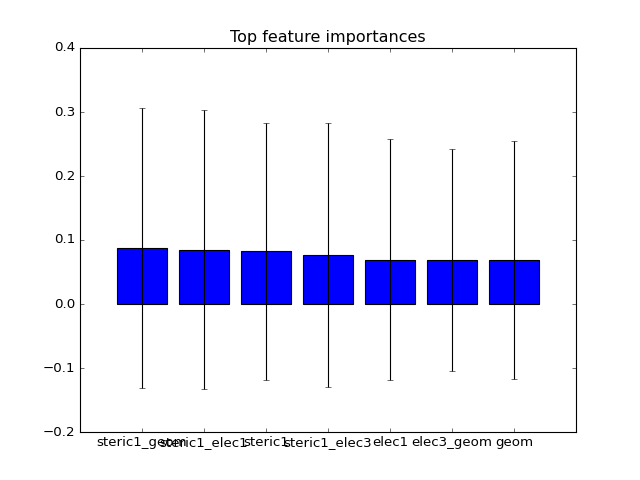

Index(['steric1', 'steric2', 'elec1', 'elec2', 'elec3', 'geom',
       'steric1_steric2', 'steric1_elec1', 'steric1_elec2', 'steric1_elec3',
       'steric1_geom', 'steric2_elec1', 'steric2_elec2', 'steric2_elec3',
       'steric2_geom', 'elec1_elec2', 'elec1_elec3', 'elec1_geom',
       'elec2_elec3', 'elec2_geom', 'elec3_geom'],
      dtype='object')


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
plt.style.use('classic')
TOP_FEATURES = 7
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                random_state=42, 
                                test_size=0.25, 
                                shuffle=True)

# model = LinearRegression()
# reg  = model.fit(X_train, y_train)

forest = ExtraTreesClassifier(n_estimators=700, max_depth=10, random_state=15)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))
    
fig = plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), X_train.keys()._data[indices])
fig.set_facecolor('white')
plt.show()
print(X_train.keys())
plt.savefig('feature_ranking.png')

### Stacking classifier

In [ ]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
import random

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                random_state=random.randrange(100), 
                                test_size=0.25, 
                                shuffle=True)


m = StackingClassifier(
    classifiers=[
        LogisticRegression(max_iter=5000),
        XGBClassifier(max_depth=10)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m = m.fit(X_train,y_train)
print(m.predict(X_test), y_test, 'R2', m.score(X_test,y_test))


### Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                random_state=random.randrange(100), 
                                test_size=0.25, 
                                shuffle=True)
regr = RandomForestRegressor(max_depth=2, random_state=random.randrange(100))
regr = regr.fit(X_train, y_train)

print(list(np.abs(np.array(y_test) - np.array(regr.predict(X_test)))/np.array(y_test) * 100))

NameError: name 'random' is not defined

### 3D Plot


0.520383693


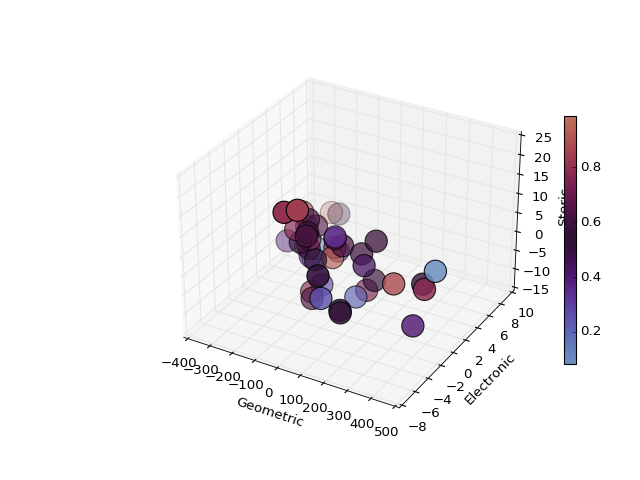

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
oh = pd.read_excel('descriptors_OH.xlsx').dropna()
dataframe =oh.groupby(['Cas']).mean()

u_geom = pca.fit_transform(dataframe[geom_keys]) 
u_steric = pca.fit_transform(dataframe[steric_keys])
u_elec = pca.fit_transform(dataframe[elec_keys])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Gen colors 
# reds = np.zeros((len(df['yield']), 3))
# for i in range(len(df['yield'])):
#     reds[i,:] = [df['yield'][i],  df['yield'][i]/10, df['yield'][i]/10]

plt.rcParams['image.cmap'] = new_cmap
print(max(np.abs(dataframe['ee'])))
p = ax.scatter(u_geom, u_elec, u_steric, c=np.abs(dataframe['yield']), s=400)
ax.set_xlabel('Geometric') # geom effects
ax.set_ylabel('Electronic') 
ax.set_zlabel('Steric')
fig.colorbar(p, fraction=0.025, pad=0.05)
fig.set_facecolor('white')
fig.savefig('3D_PCA.png', dpi=300, bbox_inches='tight')

## Ir-P bonds MLR


In [ ]:
# Pkg
import pandas as pd
import numpy as np

# Import data from distances

data = pd.read_excel('distances.xlsx')
# print(data)
data = data[data['yield'] > 0.32]
X = data.drop(['yield'], axis=1)
y = data['yield']

# Skeleton bond ->> (2.34603586872537, 2.401789943590405)
skeleton_bond = (2.34603586872537, 2.401789943590405)

print(X)

MLR(X, y)

          P1        P2
1   2.344541  2.336895
2   2.340921  2.339653
3   2.376016  2.348306
4   2.479322  2.333118
5   2.342263  2.407645
6   2.349187  2.405777
7   2.305981  2.397039
8   2.464974  2.393708
9   2.407322  2.325599
10  2.387930  2.408271
11  2.332072  2.492180
12  2.336263  2.427964
13  2.312706  2.441870
14  2.318826  2.414745
R2 =  0.5657127197588303


(array([0.24645586, 2.40084528]), -5.700254478965017)

In [ ]:

from morfeus import read_xyz
from numpy.linalg import norm
import os, glob
import numpy as np
import pandas as pd


def find_distance(xyz):
    
    elements, coordinates = read_xyz(xyz)
    
    P_coord = []
    for ind_element, element in enumerate(elements):
        if element == 'P':
            P_coord.append(ind_element)
        if element == 'Ir':
            ind_Ir = ind_element

    d1 = norm(coordinates[ind_Ir]  - coordinates[P_coord[0]])
    d2 = norm(coordinates[ind_Ir]  - coordinates[P_coord[1]])

    return d1, d2

find_distance('Skeleton_1_ferrocene.xyz')

(2.34603586872537, 2.401789943590405)